## Coelostat at Kodaikanal Tower-tunnel Telescope 
This is a specialized example of an astronomical device. The results from this are cross-checked with previous analysis of the same system as well as with a model created in the popular commercial software ```Zemax```. This also demonstrates how users can exploit the `System` class to create customized dynamic optical systems.

In [1]:
# %matplotlib inline
# %matplotlib tk
# %matplotlib qt5
import numpy as np
import sys
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random as rd
import copy as cp
from datetime import datetime as dt
#
import PyAstroPol as pap
pap.roundOffDisplay(5)

In [2]:
class KTTCoelostat(pap.System):
    def __init__(self, Sun, Sun_disp):
        #
        self.Sun = Sun
        Dec = np.radians(self.Sun.Declination)
        HA = np.radians(self.Sun.HourAngle)
        Lat = np.radians(self.Sun.Latitude)
        PolarAxis = np.array([0, np.sin(Lat), np.cos(Lat)])
        self.PolarAxis = PolarAxis
        #
        self.Dist_EW = 830.0  # East-West distance
        self.Dist_ZN = 740.0  # North-South distance
        #
        A = -np.nan_to_num(np.abs(HA)/HA, nan=-1.0)*self.Dist_EW
        B = self.Dist_ZN
        SunPos = np.array([np.sin(HA)*np.cos(Dec), 
                           np.cos(HA)*np.cos(Dec)*np.cos(Lat) + np.sin(Dec)*np.sin(Lat), 
                           -np.cos(HA)*np.cos(Dec)*np.sin(Lat) + np.sin(Dec)*np.cos(Lat)])
        #
        TEMP = np.dot(SunPos, PolarAxis)
        a = TEMP**2-PolarAxis[2]**2
        b = -2*B*PolarAxis[1]*PolarAxis[2]
        c = (A**2+B**2)*TEMP**2 - B**2*PolarAxis[1]**2
        if (a == 0):
            C = -c/b
        else:
            C = (-b + np.nan_to_num(np.abs(Dec)/Dec, nan=1.0)*np.nan_to_num(np.sqrt(b**2-4*a*c)))/2.0/a
        self.Dist_NS = np.abs(C)
        #
        self.Center1 = np.array([-A, 0.0, -C])
        self.Center2 = np.array([0.0, B, 0.0])
        #
        self.Incidence1 = -SunPos
        self.Reflection1 = np.array([A, B, C])/np.linalg.norm(np.array([A, B, C]))
        self.Normal1 = (self.Reflection1-self.Incidence1)/np.linalg.norm(self.Reflection1-self.Incidence1)
        self.Incidence2 = self.Reflection1
        self.Reflection2 = np.array([0.0, -1.0, 0.0])
        self.Normal2 = (self.Reflection2-self.Incidence2)/np.linalg.norm(self.Reflection2-self.Incidence2)
        #
        self.Sun.makeOrigin(self.Center1-self.Sun.Distance*self.Incidence1)
        Sun_disp.makeOrigin(self.Center1-self.Sun.Distance*self.Incidence1)
        #
        C12 = pap.Coating([2.16-7.18j, 1.67], [0.100, 0.00])
        self.M1 = pap.Surface(600, Mirror=True, n2=2.16-7.18j)
        self.M1.pointToDirection(self.Normal1)
        self.M1.makeOrigin(self.Center1)
        # self.M1.Coating = C12
        #
        self.M2 = pap.Surface(600, Mirror=True, n2=2.16-7.18j)
        self.M2.pointToDirection(self.Normal2)
        self.M2.makeOrigin(self.Center2)
        # self.M2.Coating = C12
        #
        self.Window = pap.Detector(500.0)
        self.Window.rotateAboutX(90.0)
        pap.System.__init__(self, self.Sun, [self.M1, self.M2], self.Window, dRays=Sun_disp)
        return

In [3]:
Sun = pap.AstroSource(10000, Clear=300, Dec=6.0, HA=21.0, Lat=10.23, Dist=5000.0)       # Position of the Sun
Sun_disp = pap.AstroSource(20, Clear=300, Dec=6.0, HA=21.0, Lat=10.23, Dist=5000.0)     # Source for display
Coel = KTTCoelostat(Sun, Sun_disp)                                                      # Coelostat configuration
Coel.propagateRays() 

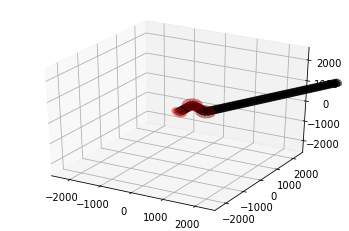

In [4]:
Fig = plt.figure()                                             
Ax = Fig.add_subplot(111, projection='3d')
Coel.draw(Ax)
pap.adjustAspect(Ax, 5000.0)
plt.show()

In [5]:
MM, Tra = Coel.getSystemMuellerMatrix()
print('Mueller matrix is : \n', MM)
print('Throughput is : ', Tra)

Mueller matrix is : 
 [[ 1.00000 -0.03828 -0.02112 -0.00051]
 [-0.04284  0.76159  0.64734  0.02923]
 [ 0.00872 -0.64387  0.75048  0.14270]
 [-0.00050  0.07046 -0.12749  0.98837]]
Throughput is :  0.7371365125883452


### Adjust relative coordinate rotation between PyAstroPol and Zemax
Final reference coordinates chosen in case of ```PyAstroPol``` and ```Zemax``` are quite different. This is compensated by following operation.

In [6]:
# print('M1 rs : ', Coel.Components[0].rs[0,0])
# print('M1 rp : ', Coel.Components[0].rp[0,0])
# print('M2 rs : ', Coel.Components[1].rs[0,0])
# print('M2 rp : ', Coel.Components[1].rp[0,0])
FinalPositionAngle = Coel.getOutputPositionAngle()
MM_ZMX_COMPARE = pap.MuellerRotationMatrix(-FinalPositionAngle)*MM
print('Mueller matrix to be compared with Zemax : \n', MM_ZMX_COMPARE)

Mueller matrix to be compared with Zemax : 
 [[ 1.00000 -0.03828 -0.02112 -0.00051]
 [-0.04092  0.98741  0.14890 -0.05117]
 [-0.01540 -0.14005  0.97985  0.13638]
 [-0.00050  0.07046 -0.12749  0.98837]]


## Comparison with ZEMAX
Zemax design file corresponding to this example is provided for checking the results. This example has two mirrors with varying relative orientations with respect to the source and detector, and with respect to rach other. This works as a good test case to cross-check the results. But, a few things before comparison :

1. A custom coating is used for this analysis. Copy and paste following snippet in Zemax coating file : ```<Zemax user data directory>/Zemax/Coatings/COATING.DAT```
    ```
    MATE CUSTMET
    0.633 2.16 -7.18 
    0.854 2.16 -7.18

    COAT CUSTMET1
    CUSTMET 0.100 1
    ```
 
2. Install Python-Zemax interface package called [PyZDDE](https://github.com/xzos/PyZDDE), using command : ``` pip install pyzdde ```

3. Open the Zemax ```OpticStudio``` (or its alternative) and load the model file ```./11_KTTCoelostat.ZMX```.

4. Run the following code.

5. In case of error with the code corresponding to ```PyZDDE```, check their github page for the issue or contact me (Personally, I have faced in few cases).

### IMPORTANT
### Albeit some information from ```PyAstroPol``` is used in ```Zemax``` model, it is only to compute proper orientation of the components and nothing more. The process of propagation and polarimetry are exclusive for each method.

In [7]:
from pyzdde import zdde as pyz
# Creating link with Zemax - user function
def createZLink(ZEMAXFileName):
    LINK = pyz.createLink()
    print('Link descritpion: ', LINK)
    if not LINK.zPushLensPermission():
        print('ERROR: Enable Allow Extensions to Push Lenses in ZEMAX>File>Preferences>Editors')
        LINK.close()
    else:
        print('Refresh the Link: ', LINK.zGetRefresh())
        LINK.zLoadFile(ZEMAXFileName)
        print('Push Lens: ', LINK.zPushLens())
    return LINK
# Setting source polarization - internal function
def setSourcePolarization(LINK, SOURCE, JX, JY, PX, PY):
    LINK.zSetNSCProperty(surfNum=1, objNum=SOURCE, faceNum=0, code=101, value=0)
    LINK.zSetNSCProperty(surfNum=1, objNum=SOURCE, faceNum=0, code=103, value=JX)
    LINK.zSetNSCProperty(surfNum=1, objNum=SOURCE, faceNum=0, code=104, value=JY)
    LINK.zSetNSCProperty(surfNum=1, objNum=SOURCE, faceNum=0, code=105, value=PX)
    LINK.zSetNSCProperty(surfNum=1, objNum=SOURCE, faceNum=0, code=106, value=PY)
# Set different input polarizations for the sake of polarimetry - internal function
def setInput(LINK, SOURCE, INT):
    if (INT == 1): # Q
        setSourcePolarization(LINK, SOURCE, 1, 0, 0, 0)
        print('Source polarization: Only Q')
    elif (INT == 2): # -Q
        setSourcePolarization(LINK, SOURCE,0, 1, 0, 0)
        print('Source polarization: Only -Q')
    elif (INT == 3): # U
        setSourcePolarization(LINK, SOURCE, 1, 1, 0, 0)
        print('Source polarization: Only U')
    elif (INT == 4): # -U
        setSourcePolarization(LINK, SOURCE, 1, -1, 0, 0)
        print('Source polarization: Only -U')
    elif (INT == 5): # V
        setSourcePolarization(LINK, SOURCE, 1, 1, 0, -90)
        print('Source polarization: Only V')
    elif (INT == 6): # -V
        setSourcePolarization(LINK, SOURCE, 1, 1, 0, 90)
        print('Source polarization: Only -V')
    else:
        print('Error: Invalid polarization code')
# Modulation implementation - internal function    
def setPolarimeterModulation(LINK, POLMETER, A_real, A_imag, B_real, B_imag, C_real, C_imag, D_real, D_imag):
    LINK.zSetNSCParameter(surfNum=1, objNum=POLMETER, paramNum=3, data=A_real)
    LINK.zSetNSCParameter(surfNum=1, objNum=POLMETER, paramNum=4, data=A_imag)
    LINK.zSetNSCParameter(surfNum=1, objNum=POLMETER, paramNum=5, data=B_real)
    LINK.zSetNSCParameter(surfNum=1, objNum=POLMETER, paramNum=6, data=B_imag)
    LINK.zSetNSCParameter(surfNum=1, objNum=POLMETER, paramNum=7, data=C_real)
    LINK.zSetNSCParameter(surfNum=1, objNum=POLMETER, paramNum=8, data=C_imag)
    LINK.zSetNSCParameter(surfNum=1, objNum=POLMETER, paramNum=9, data=D_real)
    LINK.zSetNSCParameter(surfNum=1, objNum=POLMETER, paramNum=10, data=D_imag)
# Setting modulation  - internal function 
def setModulation(LINK, POLMETER, INT): # For Stokes definition scheme
    if (INT == 1): # I+Q
        setPolarimeterModulation(LINK, POLMETER, 1, 0, 0, 0, 0, 0, 0, 0)
    elif (INT == 2): # I-Q
        setPolarimeterModulation(LINK, POLMETER, 0, 0, 0, 0, 0, 0, 1, 0)
    elif (INT == 3): # I+U
        setPolarimeterModulation(LINK, POLMETER, 0.5, 0, 0.5, 0, 0.5, 0, 0.5, 0)
    elif (INT == 4): # I-U
        setPolarimeterModulation(LINK, POLMETER, 0.5, 0, -0.5, 0, -0.5, 0, 0.5, 0)
    elif (INT == 5): # I+V
        setPolarimeterModulation(LINK, POLMETER, 0.5, 0.5, -0.5, 0.5, 0, 0, 0, 0)
    elif (INT == 6): # I-V
        setPolarimeterModulation(LINK, POLMETER, 0.5, 0.5, 0.5, -0.5, 0, 0, 0, 0)
    else:
        print('Error: Invalid modulation number')
        return    
# Run polarimetry to get system Mueller matrix - user function
def runPolarimetry(LINK, SOURCE, POLMETER):
    # Define intensity matrix
    I = np.zeros([6,6])
    LINK.zSetNSCParameter(surfNum=1, objNum=SOURCE, paramNum=2, data=100)
    for j in range(6):
        setInput(LINK, SOURCE, j+1)
        for i in range(6):
            setModulation(LINK, POLMETER, i+1)
            LINK.zNSCDetectorClear(surfNum=1)
            LINK.zNSCTrace(surfNum=1, srcNum=SOURCE, usePolar=1)
            print('Modulation: ', i+1, ' done')
            DET = LINK.zGetDetectorViewer()
            I[i,j] = DET.totPow
    LINK.zGetUpdate()
    LINK.zPushLens()
    LINK.zGetRefresh()
    return I

In [8]:
LINK = createZLink('./11_KTTCoelostat.ZMX')
LINK.zGetUpdate()
LINK.zPushLens()
LINK.zGetRefresh()
#
SOURCE, M1, M2, POLMETER, DETECTOR = 1, 2, 3, 4, 5
# Primary mirror
M1_YT = np.arcsin(Coel.Normal1[0])
M1_XT = np.arctan2(-Coel.Normal1[1]/np.cos(M1_YT), Coel.Normal1[2]/np.cos(M1_YT))
M1_X0, M1_Y0, M1_Z0 = Coel.M1.Origin - Coel.M2.Origin
# Secondary mirror
M2_YT = np.arcsin(Coel.Normal2[0])
M2_XT = np.arctan2(-Coel.Normal2[1]/np.cos(M2_YT), Coel.Normal2[2]/np.cos(M2_YT))
# Source
SOURCE_YT = np.arcsin(Coel.Incidence1[0])
SOURCE_XT = np.arctan2(-Coel.Incidence1[1]/np.cos(SOURCE_YT), Coel.Incidence1[2]/np.cos(SOURCE_YT))
SOURCE_X0 = -5000*Coel.Incidence1[0] + M1_X0
SOURCE_Y0 = -5000*Coel.Incidence1[1] + M1_Y0
SOURCE_Z0 = -5000*Coel.Incidence1[2] + M1_Z0

# Set Source parameters
LINK.zSetNSCPositionTuple(1, SOURCE, x=SOURCE_X0, y=SOURCE_Y0, z=SOURCE_Z0, 
                          tiltX=np.degrees(SOURCE_XT), tiltY=np.degrees(SOURCE_YT))
LINK.zGetUpdate()
LINK.zPushLens()
LINK.zGetRefresh()
               
# Set M1 parameters
LINK.zSetNSCPositionTuple(1, M1, x=M1_X0, y=M1_Y0, z=M1_Z0, 
                          tiltX=np.degrees(M1_XT), tiltY=np.degrees(M1_YT), 
                          material='MIRROR')
LINK.zGetUpdate()
LINK.zPushLens()
LINK.zGetRefresh()

# Set M2 parameters
LINK.zSetNSCPositionTuple(1, M2, x=0, y=0, z=0,
                          tiltX=np.degrees(M2_XT), tiltY=np.degrees(M2_YT), 
                          material='MIRROR')
LINK.zGetUpdate()
LINK.zPushLens()
LINK.zGetRefresh()

# Polarimetry to get instrumental polarization
I = runPolarimetry(LINK, SOURCE, POLMETER)
# Print results
print('Update: ', LINK.zGetUpdate())
print('Push Lens: ', LINK.zPushLens())
print('Refresh: ', LINK.zGetRefresh())
MODMATRIX = np.matrix([[1, 1, 0, 0], [1, -1, 0, 0],
                   [1, 0, 1, 0], [1, 0, -1, 0], 
                   [1, 0, 0, 1], [1, 0, 0, -1]])
DEMODMATRIX = np.linalg.inv(MODMATRIX.transpose()*MODMATRIX)*MODMATRIX.transpose()
INT_DEMOD = np.array(DEMODMATRIX*np.matrix(I))
M = np.zeros([4,4])
M[:,0] = (INT_DEMOD[:,0] + INT_DEMOD[:,1])/2
M[:,1] = (INT_DEMOD[:,0] - INT_DEMOD[:,1])/2
M[:,2] = (INT_DEMOD[:,2] - INT_DEMOD[:,3])/2
M[:,3] = (INT_DEMOD[:,4] - INT_DEMOD[:,5])/2
MULL_SIM = M/M[0,0]
LINK.close()

Link descritpion:  PyZDDE(appName='ZEMAX', appNum=1, connection=True, macroPath=None)
Refresh the Link:  0
Push Lens:  0
Source polarization: Only Q
Modulation:  1  done
Modulation:  2  done
Modulation:  3  done
Modulation:  4  done
Modulation:  5  done
Modulation:  6  done
Source polarization: Only -Q
Modulation:  1  done
Modulation:  2  done
Modulation:  3  done
Modulation:  4  done
Modulation:  5  done
Modulation:  6  done
Source polarization: Only U
Modulation:  1  done
Modulation:  2  done
Modulation:  3  done
Modulation:  4  done
Modulation:  5  done
Modulation:  6  done
Source polarization: Only -U
Modulation:  1  done
Modulation:  2  done
Modulation:  3  done
Modulation:  4  done
Modulation:  5  done
Modulation:  6  done
Source polarization: Only V
Modulation:  1  done
Modulation:  2  done
Modulation:  3  done
Modulation:  4  done
Modulation:  5  done
Modulation:  6  done
Source polarization: Only -V
Modulation:  1  done
Modulation:  2  done
Modulation:  3  done
Modulation:  4 

In [9]:
print('From Zemax : \n', MULL_SIM)
print('From My code : \n', MM_ZMX_COMPARE)

From Zemax : 
 [[ 1.00000 -0.03828 -0.02112 -0.00051]
 [-0.04091  0.98741  0.14889 -0.05116]
 [-0.01540 -0.14006  0.97985  0.13639]
 [-0.00051  0.07046 -0.12749  0.98837]]
From My code : 
 [[ 1.00000 -0.03828 -0.02112 -0.00051]
 [-0.04092  0.98741  0.14890 -0.05117]
 [-0.01540 -0.14005  0.97985  0.13638]
 [-0.00050  0.07046 -0.12749  0.98837]]
